
--- Mapping to a Right-Angle Triangle ---
Right Triangle Vertices (w): [0j, (1+0j), 1j]
Using Manual Betas: [-0.5, -0.75, -0.75]
Assumed Prevertices (z): [-1.0, 0.0, 1.0]
Calculating C1 using quad between [-1.0, 0.0] with points [-1.0, 0.0]...
Integral value for C1 calculation (using quad): (-7.982034475594078e-17-0.44031501082007013j)
Determined Constant C1: (-4.117054505715005e-16+2.2711013148008234j)
Mapping grid points...
Mapping complete.


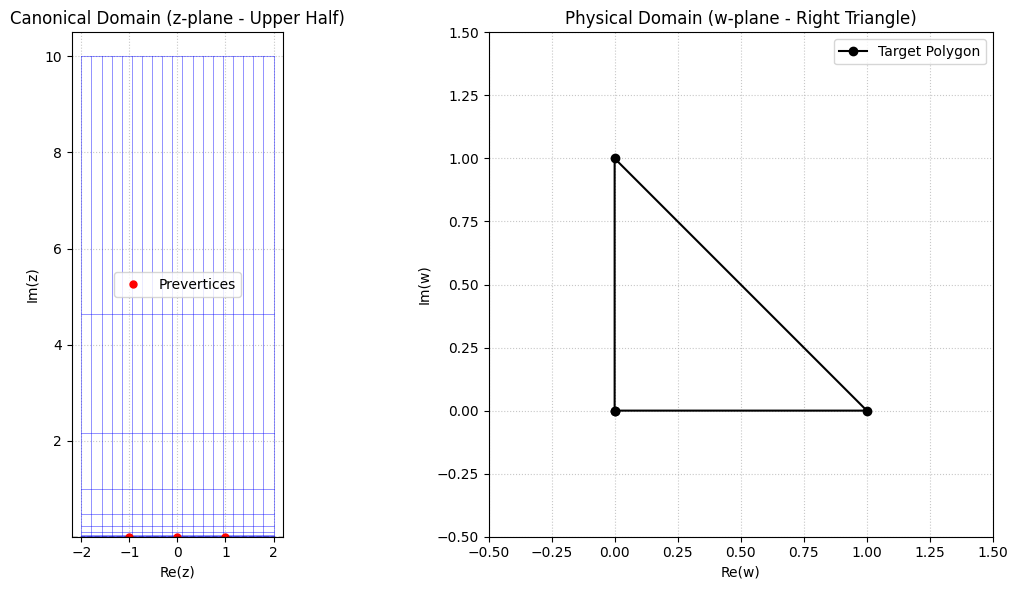


--- Notes ---
1. Parameter Problem: Finding prevertices for a given polygon is non-trivial.
2. Numerical Integration: Accuracy depends on the integrator and handling singularities near prevertices. Using 'points' argument helps.
3. Constant C1: Determination requires mapping at least one known point pair or segment. Integration requires care.
4. Streamlines: To visualize flow, map streamlines (e.g., horizontal lines in UHP for uniform flow) using this transformation.
5. Libraries: Specialized libraries like Driscoll's SCToobox for MATLAB/Python handle complexities robustly.
6. Angle Calculation: The `calculate_betas` function may need review for robustness; manual betas used in this example.


In [2]:
import numpy as np
# Import quad alongside quad_vec
from scipy.integrate import quad, quad_vec
import matplotlib.pyplot as plt
import cmath # For complex number operations
import traceback # For printing error details

# --- Core Schwarz-Christoffel Functions ---

def sc_integrand(zeta, prevertices, betas):
  """
  Calculates the integrand of the Schwarz-Christoffel formula.
  f'(zeta) = C1 * product( (zeta - z_k)^(-beta_k) )

  Args:
    zeta (complex or array-like): Points in the canonical domain (upper half-plane).
    prevertices (list/array): Points z_k on the real axis (or boundary of canonical domain).
    betas (list/array): Exterior angle parameters (alpha_k / pi - 1). alpha_k is interior angle.

  Returns:
    complex or array-like: Value(s) of the integrand at zeta.
  """
  # Ensure zeta is complex array
  zeta = np.asarray(zeta, dtype=complex)
  integrand = np.ones_like(zeta, dtype=complex)
  for zk, beta_k in zip(prevertices, betas):
      # Add a small epsilon to avoid issues if zeta is exactly zk during integration
      # Note: Robust handling of singularities is complex. Epsilon is a simple approach.
      epsilon = 1e-12 # Slightly larger epsilon might help stability
      term = (zeta - zk + epsilon)**(-beta_k)
      integrand *= term
  return integrand

# --- Updated sc_map function ---
def sc_map(z, z_ref, w_ref, prevertices, betas, C1=1.0):
    """
    Computes the Schwarz-Christoffel map f(z) using numerical integration.
    f(z) = w_ref + C1 * integral_{z_ref}^{z} [product( (zeta - z_k)^(-beta_k) )] dzeta

    Args:
      z (complex or array-like): Points in the canonical domain (upper half-plane) to map.
      z_ref (complex): A reference point in the canonical domain.
      w_ref (complex): The corresponding mapped point f(z_ref) in the physical domain (polygon).
      prevertices (list/array): Points z_k on the real axis.
      betas (list/array): Exterior angle parameters.
      C1 (complex): Scaling/rotation constant. Needs to be determined.

    Returns:
      complex or array-like: Mapped points w = f(z) in the physical domain.
    """
    z = np.asarray(z, dtype=complex)
    results = np.zeros_like(z, dtype=complex)
    # Get finite real prevertices to pass to integrator as potential difficulties
    finite_real_prevertices = [p for p in prevertices if np.isreal(p) and np.isfinite(p)]

    # Integrate for each point in z individually
    for i, target_z in np.ndenumerate(z):
        # Define the integration path (straight line from z_ref to target_z)
        # Pass prevertices to help integrator handle singularities near the path
        try:
            integral_val, abserr = quad_vec(
                lambda zeta: sc_integrand(zeta, prevertices, betas),
                z_ref,
                target_z,
                # Pass known singularity points on the real axis
                points=finite_real_prevertices
            )
            results[i] = w_ref + C1 * integral_val
        except Exception as e:
            # Print warning for the specific point that failed
            print(f"Warning: Integration failed for z={target_z} (index {i}) from z_ref={z_ref}. Error: {e}")
            # Mark failed points as NaN (Not a Number)
            results[i] = complex(np.nan, np.nan)

    return results

# --- Helper Functions ---

# NOTE: This function might not calculate angles correctly for all polygon configurations.
# It's kept here for reference but overridden in the example below.
def calculate_betas(vertices):
    """
    Calculates the exterior angle parameters beta_k from polygon vertices.
    beta_k = (exterior angle)_k / pi = 1 - (interior angle)_k / pi

    Args:
      vertices (list/array): List of complex numbers representing polygon vertices in order (CCW).

    Returns:
      list: List of beta parameters.
    """
    print("Warning: calculate_betas may not be robust. Verify results.")
    n = len(vertices)
    betas = []
    for k in range(n):
        w_prev = vertices[(k - 1 + n) % n]
        w_curr = vertices[k]
        w_next = vertices[(k + 1) % n]

        vec1 = w_prev - w_curr # Vector pointing into vertex
        vec2 = w_next - w_curr # Vector pointing away from vertex

        if abs(vec1) < 1e-12 or abs(vec2) < 1e-12:
             raise ValueError(f"Degenerate vertex or zero-length side at index {k}")

        # Calculate interior angle: angle from vec1 to vec2
        interior_angle = cmath.phase(vec2 / vec1)

        # Ensure angle is positive CCW angle [0, 2*pi)
        if interior_angle < 0:
            interior_angle += 2 * np.pi

        # Beta = alpha/pi - 1
        beta_k = interior_angle / np.pi - 1.0
        betas.append(beta_k)

    # Check: Sum of betas should be -2 for a closed polygon
    sum_betas = np.sum(betas)
    if not np.isclose(sum_betas, -2.0):
        print(f"Warning: Sum of betas is {sum_betas:.4f}, expected -2. Check vertex order (CCW) or angle calculation.")

    return betas


# --- Example: Equilateral Triangle (Commented out for now) ---
# print("--- Mapping to an Equilateral Triangle ---")
# ... (keep code but maybe comment out execution) ...

# --- Example: Right-Angle Triangle (Focus of the fix) ---
print("\n--- Mapping to a Right-Angle Triangle ---")
# Vertices: (0,0), (1,0), (0,1) -> Angles: pi/2, pi/4, pi/4
w_rt1 = complex(0, 0)
w_rt2 = complex(1, 0)
w_rt3 = complex(0, 1)
# Ensure Counter-Clockwise (CCW) order for angle calculation convention
rt_triangle_vertices = [w_rt1, w_rt2, w_rt3]
print(f"Right Triangle Vertices (w): {rt_triangle_vertices}")

# Use manually calculated correct betas for this triangle
# Interior angles (rad): pi/2, pi/4, pi/4
# Betas = alpha/pi - 1: -0.5, -0.75, -0.75
# NOTE: Overriding the calculate_betas function call here.
betas_rt = [-0.5, -0.75, -0.75] # Corresponds to vertices w_rt1, w_rt2, w_rt3
print(f"Using Manual Betas: {betas_rt}") # Check sum is -2 (-0.5 - 0.75 - 0.75 = -2.0)

# Prevertices (Assume known for this example - solving this is the 'parameter problem')
# Assumed mapping: z=-1 -> w=(0,0), z=0 -> w=(1,0), z=1 -> w=(0,1)
prevertices_rt = [-1.0, 0.0, 1.0]
print(f"Assumed Prevertices (z): {prevertices_rt}")

# 4. Determine Constants C1 and C2 (Translation/Scaling)
# C2 is handled by w_ref. We need C1.
# Map segment z=[-1, 0] to w=[w_rt1, w_rt2] = [0, 1]
# f(0) = f(-1) + C1 * integral_{-1}^{0} [integrand] dz
# w_rt2 = w_rt1 + C1 * integral
# (w_rt2 - w_rt1) = C1 * integral
# C1 = (w_rt2 - w_rt1) / integral

integrand_for_c1 = lambda zeta: sc_integrand(zeta, prevertices_rt, betas_rt)
integral_val_c1 = complex(0, 0) # Initialize
C1 = 1.0 # Default value if integration fails

# Use quad for this single complex integral - potentially more robust for endpoint singularities
# Integrate real and imaginary parts separately
integration_limits = [-1.0, 0.0]
# Identify singularities within (or at endpoints of) the integration interval
relevant_singularities = [p for p in prevertices_rt if integration_limits[0] <= p <= integration_limits[1]]

print(f"Calculating C1 using quad between {integration_limits} with points {relevant_singularities}...")
try:
    real_integral, abserr_real = quad(
        lambda zeta: np.real(integrand_for_c1(zeta)),
        integration_limits[0], integration_limits[1],
        points=relevant_singularities # Help integrator handle singularities
    )
    imag_integral, abserr_imag = quad(
        lambda zeta: np.imag(integrand_for_c1(zeta)),
        integration_limits[0], integration_limits[1],
        points=relevant_singularities
    )
    integral_val_c1 = complex(real_integral, imag_integral)
    print(f"Integral value for C1 calculation (using quad): {integral_val_c1}")

    # Calculate C1 = delta_w / integral_val
    target_segment = rt_triangle_vertices[1] - rt_triangle_vertices[0] # Should be 1.0
    if abs(target_segment) < 1e-12:
         print("Warning: Target segment for C1 calculation has zero length.")
         C1 = 1.0 # Fallback
    elif abs(integral_val_c1) > 1e-9: # Avoid division by zero
        C1 = target_segment / integral_val_c1
    else:
        print(f"Warning: Integral for C1 ({integral_val_c1}) is close to zero. Cannot determine C1 reliably.")
        C1 = 1.0 # Default fallback

except Exception as e:
    print(f"Error during C1 integration with quad: {e}")
    traceback.print_exc() # Print detailed error information
    print("Falling back to default C1=1.0")
    C1 = 1.0

print(f"Determined Constant C1: {C1}")

# 5. Map Points from Upper Half-Plane (UHP)
# Define points in UHP (e.g., a grid)
nx, ny = 20, 10 # Grid density
x_real = np.linspace(-2, 2, nx)
y_imag = np.logspace(-2, 1, ny) # Use logspace to get closer to real axis
X, Y = np.meshgrid(x_real, y_imag)
Z_uhp = X + 1j * Y

# Use z_ref = -1 (a prevertex) and w_ref = w_rt1 (corresponding vertex)
# Ensure reference point is slightly off the real axis if it's a prevertex
# to avoid starting integration exactly at a singularity for sc_map/quad_vec.
# However, z=-1 corresponds to w=0, which should be the exact mapping.
# Let's keep z_ref on the axis but rely on the integrator handling.
z_reference = complex(-1.0, 0.0)
w_reference = rt_triangle_vertices[0] # w=0+0j

# Perform the mapping using the updated sc_map
print("Mapping grid points...")
W_mapped_flat = sc_map(Z_uhp.flatten(), z_reference, w_reference, prevertices_rt, betas_rt, C1)
W_mapped = W_mapped_flat.reshape(Z_uhp.shape) # Reshape back to grid
print("Mapping complete.")

# --- Visualization ---
# Handle potential NaNs in the mapped data by masking them for plotting
W_mapped_real = np.real(W_mapped)
W_mapped_imag = np.imag(W_mapped)
mask = np.isfinite(W_mapped_real) & np.isfinite(W_mapped_imag)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Original grid in the Upper Half-Plane (z-plane)
axs[0].set_title("Canonical Domain (z-plane - Upper Half)")
axs[0].plot(X, Y, 'b-', lw=0.5, alpha=0.6) # Horizontal lines
axs[0].plot(X.T, Y.T, 'b-', lw=0.5, alpha=0.6) # Vertical lines
axs[0].plot(np.real(prevertices_rt), np.imag(prevertices_rt), 'ro', markersize=5, label='Prevertices')
axs[0].set_xlabel("Re(z)")
axs[0].set_ylabel("Im(z)")
axs[0].set_ylim(bottom=1e-3) # Avoid plotting axis itself if y starts at 0
axs[0].axhline(0, color='k', linestyle='--', lw=1)
axs[0].legend()
axs[0].grid(True, linestyle=':', alpha=0.7)
axs[0].set_aspect('equal', adjustable='box')

# Plot 2: Mapped grid in the Physical Domain (w-plane)
axs[1].set_title("Physical Domain (w-plane - Right Triangle)")
# Plot mapped grid lines, handling potential NaNs (gaps will appear)
for i in range(W_mapped.shape[0]): # Plot horizontal lines
     axs[1].plot(W_mapped_real[i, :][mask[i, :]], W_mapped_imag[i, :][mask[i, :]], 'g-', lw=0.5, alpha=0.7)
for j in range(W_mapped.shape[1]): # Plot vertical lines
     axs[1].plot(W_mapped_real[:, j][mask[:, j]], W_mapped_imag[:, j][mask[:, j]], 'g-', lw=0.5, alpha=0.7)

# Plot polygon vertices
poly_w = np.array(rt_triangle_vertices + [rt_triangle_vertices[0]]) # Close the polygon for plotting
axs[1].plot(np.real(poly_w), np.imag(poly_w), 'k-o', linewidth=1.5, markersize=6, label='Target Polygon')
axs[1].set_xlabel("Re(w)")
axs[1].set_ylabel("Im(w)")
axs[1].legend()
axs[1].grid(True, linestyle=':', alpha=0.7)
axs[1].set_aspect('equal', adjustable='box')
# Set limits based on polygon bounds + margin
axs[1].set_xlim(-0.5, 1.5)
axs[1].set_ylim(-0.5, 1.5)


plt.tight_layout()
plt.show()

print("\n--- Notes ---")
print("1. Parameter Problem: Finding prevertices for a given polygon is non-trivial.")
print("2. Numerical Integration: Accuracy depends on the integrator and handling singularities near prevertices. Using 'points' argument helps.")
print("3. Constant C1: Determination requires mapping at least one known point pair or segment. Integration requires care.")
print("4. Streamlines: To visualize flow, map streamlines (e.g., horizontal lines in UHP for uniform flow) using this transformation.")
print("5. Libraries: Specialized libraries like Driscoll's SCToobox for MATLAB/Python handle complexities robustly.")
print("6. Angle Calculation: The `calculate_betas` function may need review for robustness; manual betas used in this example.")



Setup Complete. Using NumPy 1.25.2, SciPy 1.25.2
Target Polygon: L-shape with 6 vertices.
Interior angles (alpha_j * pi): [1.57079633 4.71238898 1.57079633 1.57079633 1.57079633 1.57079633]
Check sum(alphas) = 4.0 vs n-2 = 4
ASSUMED finite prevertices (a_j): [-2. -1.  0.  1.  2.]
ASSUMED Constant C = (0.5+0j)
ASSUMED Constant A = 0j (based on w_1)
Integration base point z0 = (-2+0j)

Mapping grid points (this may take some time)...
  Mapped point 50 / 600
  Mapped point 100 / 600
  Mapped point 150 / 600
  Mapped point 200 / 600
  Mapped point 250 / 600
  Mapped point 300 / 600
  Mapped point 350 / 600
  Mapped point 400 / 600
  Mapped point 450 / 600
  Mapped point 500 / 600
  Mapped point 550 / 600
  Mapped point 600 / 600
Grid mapping complete.
Generating plots...
Mapping prevertices:
  f(-2.00) -> 0.000 + 0.000j
  f(-1.00) -> -0.189 + -0.000j
  f(0.00) -> -0.189 + 0.361j
  f(1.00) -> -1.202 + 0.361j
  f(2.00) -> -1.202 + -0.741j


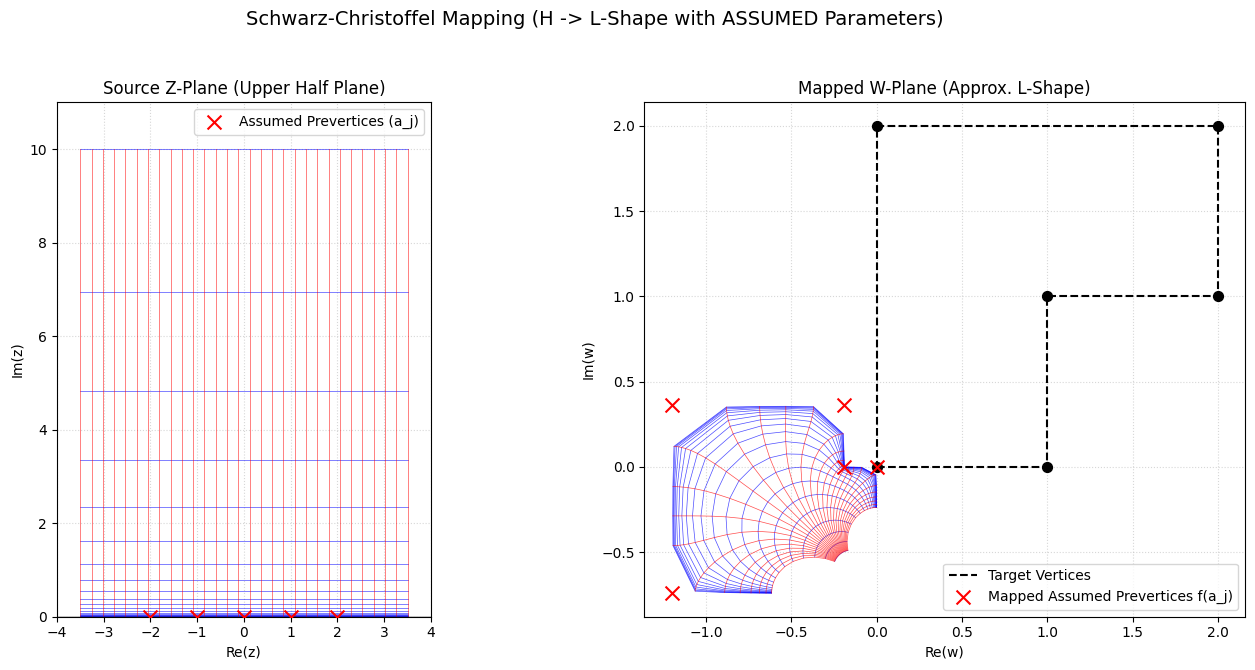


Done.


In [3]:
# SECTION 1: IMPORTS AND SETUP
# ==================================================
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import warnings

# Filter out potential warnings from complex arithmetic during integration
warnings.filterwarnings("ignore", category=integrate.IntegrationWarning)

print(f"Setup Complete. Using NumPy {np.__version__}, SciPy {np.__version__}")

# SECTION 2: POLYGON DEFINITION AND (ASSUMED) PARAMETERS
# ==================================================

# Define the target L-shaped polygon vertices (counter-clockwise)
# Example: L-shape from (0,0) to (1,0) to (1,1) to (2,1) to (2,2) to (0,2)
w_vertices = np.array([0+0j, 1+0j, 1+1j, 2+1j, 2+2j, 0+2j])
n_vertices = len(w_vertices)
print(f"Target Polygon: L-shape with {n_vertices} vertices.")

# Calculate exterior angles beta_j * pi = (1 - alpha_j) * pi
# Interior angles alpha_j * pi are: pi/2, 3pi/2, pi/2, pi/2, pi/2, pi/2
alphas = np.array([0.5, 1.5, 0.5, 0.5, 0.5, 0.5])
betas = 1.0 - alphas # Exterior turn angles / pi
print(f"Interior angles (alpha_j * pi): {alphas * np.pi}")
print(f"Check sum(alphas) = {np.sum(alphas)} vs n-2 = {n_vertices - 2}")
# Check: Sum should be n-2 for polygon mapped from H (one vertex at inf)

# --- SC Parameter Placeholder ---
# !! CRITICAL CAVEAT !!
# These parameters (a_prevertices, C_const, A_const) are ASSUMED for demonstration.
# In a real project, they MUST be found by numerically solving the parameter problem.
# We map from the Upper Half Plane (H). One vertex (w_n) maps to infinity.
# We need n-1 finite prevertices on the real axis corresponding to w_1...w_{n-1}.

# ASSUMED Prevertices (locations on real axis corresponding to w_1 to w_{n-1})
# These values are *guesses* and likely not correct for the target w_vertices.
a_prevertices_finite = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
print(f"ASSUMED finite prevertices (a_j): {a_prevertices_finite}")

# ASSUMED Constants
# C determines overall scaling and rotation.
C_const = 0.5 + 0j # Let's try scaling it down a bit from 1.
# A is an integration constant, related to the position of the first vertex.
# If we choose base point z0 = a_1, then A should be w_1.
z0_integration_base = a_prevertices_finite[0] + 0j # Start integral from first prevertex
A_const = w_vertices[0] # Set A so that f(a_1) should be w_1.
print(f"ASSUMED Constant C = {C_const}")
print(f"ASSUMED Constant A = {A_const} (based on w_1)")
print(f"Integration base point z0 = {z0_integration_base}")


# SECTION 3: SC INTEGRAND AND INTEGRATION FUNCTIONS
# ==================================================

def sc_integrand_H_inf(z, C, a_finite, alpha_all):
    """
    Calculates the Schwarz-Christoffel integrand for mapping H to Polygon.
    Formula: C * Product_{j=1}^{n-1} [ (z - a_j)^(alpha_j - 1) ]
    Assumes a_n = infinity. alpha_all must contain all n alphas.
    The j-th element of a_finite corresponds to the j-th element of alpha_all.
    """
    prod = C + 0j # Ensure complex type
    for j in range(len(a_finite)):
        term = z - a_finite[j]
        # Handle potential issues near branch cuts or zero using complex power
        # np.power handles complex base and exponent correctly.
        power = alpha_all[j] - 1.0
        try:
            # Add small epsilon to imaginary part if z is exactly on negative real axis relative to a_j
            # This helps np.power select the correct branch consistent with H.
            # if term.imag == 0 and term.real <= 0:
            #    term += 1e-15j # May or may not be needed depending on path integrator
            
            prod *= np.power(term, power)
        except (ValueError, ZeroDivisionError, OverflowError):
             # Return NaN or Inf if evaluation fails (e.g., z lands exactly on a singularity)
             print(f"Warning: Problem evaluating term for z={z}, a_j={a_finite[j]}, power={power}")
             return np.nan + 0j
    return prod

def complex_path_integral(func, z_start, z_end, steps=100, **kwargs):
    """
    Integrates a complex function 'func(z)' along a straight line path
    from complex z_start to z_end using scipy.integrate.quad.
    Splits into real and imaginary parts for quad.
    kwargs are passed to quad (e.g., epsabs, epsrel).
    """
    path_vector = z_end - z_start
    if abs(path_vector) < 1e-12: # Avoid zero-length path
        return 0j, 0.0

    def real_integrand(t):
        z_t = z_start + t * path_vector # Point on path at parameter t (0 to 1)
        integrand_val = func(z_t)
        return np.real(integrand_val * path_vector) # dz = path_vector * dt

    def imag_integrand(t):
        z_t = z_start + t * path_vector
        integrand_val = func(z_t)
        return np.imag(integrand_val * path_vector)

    try:
        # Integrate real and imaginary parts separately
        real_integral, real_abserr = integrate.quad(real_integrand, 0, 1, limit=steps, **kwargs)
        imag_integral, imag_abserr = integrate.quad(imag_integrand, 0, 1, limit=steps, **kwargs)
        total_abserr = np.sqrt(real_abserr**2 + imag_abserr**2) # Combine errors
        return real_integral + 1j * imag_integral, total_abserr
    except Exception as e:
        print(f"Integration failed from {z_start} to {z_end}: {e}")
        return np.nan + 1j*np.nan, np.inf


# SECTION 4: FORWARD MAP FUNCTION
# ==================================================

def sc_map_forward_H(z, A, C, a_finite, alpha_all, z0):
    """
    Calculates the SC forward map f(z) = A + integral_{z0}^{z} integrand(t) dt.
    Uses the specific integrand for H -> Polygon (vertex at inf).
    """
    # Define the integrand with fixed parameters for this map
    integrand_to_use = lambda t: sc_integrand_H_inf(t, C, a_finite, alpha_all)

    # Perform the complex path integral from base point z0 to z
    integral_val, abserr = complex_path_integral(integrand_to_use, z0, z, steps=200, epsabs=1e-6, epsrel=1e-6)

    # Check if integration returned NaN
    if np.isnan(integral_val):
        print(f"Mapping failed for z={z}, integral returned NaN.")
        return np.nan + 1j*np.nan

    return A + integral_val


# SECTION 5: APPLICATION - MAP GRID AND VISUALIZE
# ==================================================
print("\nMapping grid points (this may take some time)...")

# Create a grid in the source domain (Upper Half Plane)
nx, ny = 30, 20 # Grid density
x_real = np.linspace(-3.5, 3.5, nx)
# Use logspace for y to get better resolution near the real axis
y_imag = np.logspace(-2, 1, ny) # From 0.01 up to 10
X_z, Y_z = np.meshgrid(x_real, y_imag)
Z_grid_source = X_z + 1j * Y_z

# Apply the SC map to each grid point
W_grid_mapped = np.full_like(Z_grid_source, np.nan + 1j*np.nan, dtype=complex) # Initialize with NaN

total_points = nx * ny
count = 0
for i in range(nx):
    for j in range(ny):
        z_point = Z_grid_source[j, i]
        W_grid_mapped[j, i] = sc_map_forward_H(
            z_point, A_const, C_const, a_prevertices_finite, alphas, z0_integration_base
        )
        count += 1
        if count % 50 == 0 or count == total_points:
             print(f"  Mapped point {count} / {total_points}")

print("Grid mapping complete.")

# --- Visualization ---
print("Generating plots...")
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
plt.suptitle("Schwarz-Christoffel Mapping (H -> L-Shape with ASSUMED Parameters)", fontsize=14)

# Subplot 1: Source Grid in Z-plane (Upper Half Plane)
axs[0].set_title("Source Z-Plane (Upper Half Plane)")
axs[0].set_xlabel("Re(z)")
axs[0].set_ylabel("Im(z)")
# Plot grid lines
for j in range(ny): # Horizontal lines
    axs[0].plot(Z_grid_source[j, :].real, Z_grid_source[j, :].imag, 'b-', lw=0.5, alpha=0.7)
for i in range(nx): # Vertical lines
    axs[0].plot(Z_grid_source[:, i].real, Z_grid_source[:, i].imag, 'r-', lw=0.5, alpha=0.7)
# Plot finite prevertices on the real axis
axs[0].scatter(a_prevertices_finite.real, np.zeros_like(a_prevertices_finite),
               c='red', marker='x', s=100, zorder=5, label='Assumed Prevertices (a_j)')
axs[0].set_xlim(x_real.min() - 0.5, x_real.max() + 0.5)
axs[0].set_ylim(0, y_imag.max() * 1.1)
axs[0].axhline(0, color='black', lw=1) # Draw real axis
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend()
axs[0].grid(True, linestyle=':', alpha=0.5)

# Subplot 2: Mapped Grid in W-plane
axs[1].set_title("Mapped W-Plane (Approx. L-Shape)")
axs[1].set_xlabel("Re(w)")
axs[1].set_ylabel("Im(w)")
# Plot mapped grid lines (only plot if not NaN)
for j in range(ny): # Images of horizontal lines
    mask = ~np.isnan(W_grid_mapped[j, :])
    if np.any(mask):
        axs[1].plot(W_grid_mapped[j, mask].real, W_grid_mapped[j, mask].imag, 'b-', lw=0.5, alpha=0.7)
for i in range(nx): # Images of vertical lines
    mask = ~np.isnan(W_grid_mapped[:, i])
    if np.any(mask):
        axs[1].plot(W_grid_mapped[mask, i].real, W_grid_mapped[mask, i].imag, 'r-', lw=0.5, alpha=0.7)

# Plot target polygon vertices for reference (dashed line)
target_poly_closed = np.append(w_vertices, w_vertices[0]) # Close the loop
axs[1].plot(target_poly_closed.real, target_poly_closed.imag, 'k--', lw=1.5, label='Target Vertices')
axs[1].scatter(w_vertices.real, w_vertices.imag, c='black', marker='o', s=50, zorder=5)

# Map the prevertices to see where they land (using the forward map)
w_mapped_prevertices = []
print("Mapping prevertices:")
for idx, a_j in enumerate(a_prevertices_finite):
     # Integrate slightly into the upper half plane from z0 to avoid issues if a_j=z0
     # or if integration path runs exactly along real axis segment with singularity
     offset = 1e-7j
     if idx==0: # a_1 is the base point z0
         w_map = A_const
     else:
         w_map = sc_map_forward_H(a_j + offset, A_const, C_const, a_prevertices_finite, alphas, z0_integration_base)
     print(f"  f({a_j:.2f}) -> {w_map.real:.3f} + {w_map.imag:.3f}j")
     w_mapped_prevertices.append(w_map)

w_mapped_prevertices = np.array(w_mapped_prevertices)
axs[1].scatter(w_mapped_prevertices.real, w_mapped_prevertices.imag,
               c='red', marker='x', s=100, zorder=5, label='Mapped Assumed Prevertices f(a_j)')

axs[1].set_aspect('equal', adjustable='box')
axs[1].legend()
axs[1].grid(True, linestyle=':', alpha=0.5)
# Auto-adjust limits, or set manually if needed
axs[1].autoscale_view()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

print("\nDone.")


Mapping streamlines (this may take some time)...
  Mapped streamline 1 / 20
  Mapped streamline 2 / 20
  Mapped streamline 3 / 20
  Mapped streamline 4 / 20
  Mapped streamline 5 / 20
  Mapped streamline 6 / 20
  Mapped streamline 7 / 20
  Mapped streamline 8 / 20
  Mapped streamline 9 / 20
  Mapped streamline 10 / 20
  Mapped streamline 11 / 20
  Mapped streamline 12 / 20
  Mapped streamline 13 / 20
  Mapped streamline 14 / 20
  Mapped streamline 15 / 20
  Mapped streamline 16 / 20
  Mapped streamline 17 / 20
  Mapped streamline 18 / 20
  Mapped streamline 19 / 20
  Mapped streamline 20 / 20
Streamline mapping complete.
Generating plots...
Mapping prevertices:
  f(-2.00) -> 0.000 + 0.000j
  f(-1.00) -> -0.189 + -0.000j
  f(0.00) -> -0.189 + 0.361j
  f(1.00) -> -1.202 + 0.361j
  f(2.00) -> -1.202 + -0.741j


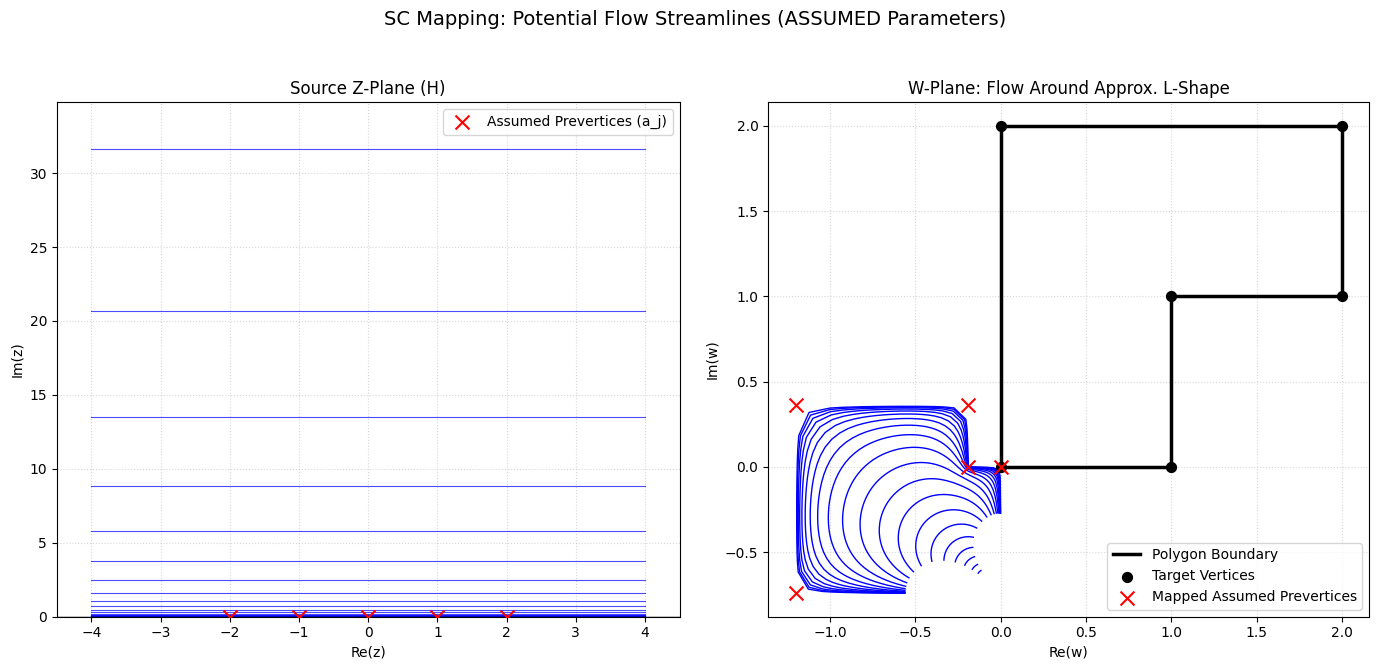


Done.


In [4]:
# (Keep Sections 1, 2, 3, 4 as before)
# ... Imports ...
# ... Polygon Definition and ASSUMED Parameters ...
# ... SC Integrand and Integration Functions ...
# ... Forward Map Function ...

# SECTION 5: APPLICATION - MAP STREAMLINES AND VISUALIZE
# ==================================================
print("\nMapping streamlines (this may take some time)...")

# Define horizontal streamlines in the source domain (Upper Half Plane)
num_streamlines = 20
# y-values for streamlines (logspace focuses near the boundary)
y_stream_vals = np.logspace(-2, 1.5, num_streamlines) # Im(z) = constant
# x-values along each streamline
x_range = np.linspace(a_prevertices_finite.min() - 2, a_prevertices_finite.max() + 2, 150) # Wider range

streamlines_source_z = []
for y_k in y_stream_vals:
    streamlines_source_z.append(x_range + 1j * y_k)

# Apply the SC map to each point on each streamline
streamlines_mapped_w = []
total_streamlines = len(streamlines_source_z)
count = 0
for idx, z_line in enumerate(streamlines_source_z):
    w_line = np.full_like(z_line, np.nan + 1j*np.nan, dtype=complex)
    for i, z_point in enumerate(z_line):
        # Use the forward map function defined in Section 4
        w_line[i] = sc_map_forward_H(
            z_point, A_const, C_const, a_prevertices_finite, alphas, z0_integration_base
        )
    streamlines_mapped_w.append(w_line)
    count += 1
    print(f"  Mapped streamline {count} / {total_streamlines}")

print("Streamline mapping complete.")

# --- Visualization ---
print("Generating plots...")
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
plt.suptitle("SC Mapping: Potential Flow Streamlines (ASSUMED Parameters)", fontsize=14)

# Subplot 1: Source Z-Plane (Upper Half Plane) with Streamlines
axs[0].set_title("Source Z-Plane (H)")
axs[0].set_xlabel("Re(z)")
axs[0].set_ylabel("Im(z)")
# Plot source streamlines
for z_line in streamlines_source_z:
    axs[0].plot(z_line.real, z_line.imag, 'b-', lw=0.8, alpha=0.7)
# Plot finite prevertices on the real axis
axs[0].scatter(a_prevertices_finite.real, np.zeros_like(a_prevertices_finite),
               c='red', marker='x', s=100, zorder=5, label='Assumed Prevertices (a_j)')
axs[0].set_xlim(x_range.min() - 0.5, x_range.max() + 0.5)
axs[0].set_ylim(0, y_stream_vals.max() * 1.1)
axs[0].axhline(0, color='black', lw=1) # Draw real axis
# axs[0].set_aspect('equal', adjustable='box') # Aspect ratio might make plot tall
axs[0].legend()
axs[0].grid(True, linestyle=':', alpha=0.5)

# Subplot 2: Mapped Streamlines in W-plane
axs[1].set_title("W-Plane: Flow Around Approx. L-Shape")
axs[1].set_xlabel("Re(w)")
axs[1].set_ylabel("Im(w)")
# Plot mapped streamlines (only plot valid points)
for w_line in streamlines_mapped_w:
    mask = ~np.isnan(w_line) # Filter out any NaNs from failed integrations
    if np.any(mask):
        axs[1].plot(w_line[mask].real, w_line[mask].imag, 'b-', lw=1.0)

# Plot the polygon boundary solidly
polygon_boundary = np.append(w_vertices, w_vertices[0])
axs[1].plot(polygon_boundary.real, polygon_boundary.imag, 'k-', lw=2.5, zorder=3, label='Polygon Boundary')

# Plot target vertices for reference
axs[1].scatter(w_vertices.real, w_vertices.imag, c='black', marker='o', s=50, zorder=5, label='Target Vertices')

# Plot where the assumed prevertices actually mapped
# (Code to calculate w_mapped_prevertices is the same as before)
# ... (calculate w_mapped_prevertices) ...
# Add this calculation block here if you didn't run it just before plotting
w_mapped_prevertices = []
print("Mapping prevertices:")
for idx, a_j in enumerate(a_prevertices_finite):
     offset = 1e-7j
     if idx==0: # a_1 is the base point z0
         w_map = A_const
     else:
         w_map = sc_map_forward_H(a_j + offset, A_const, C_const, a_prevertices_finite, alphas, z0_integration_base)
     print(f"  f({a_j:.2f}) -> {w_map.real:.3f} + {w_map.imag:.3f}j")
     w_mapped_prevertices.append(w_map)
w_mapped_prevertices = np.array(w_mapped_prevertices)

axs[1].scatter(w_mapped_prevertices.real, w_mapped_prevertices.imag,
               c='red', marker='x', s=100, zorder=5, label='Mapped Assumed Prevertices')


axs[1].set_aspect('equal', adjustable='box')
axs[1].legend()
axs[1].grid(True, linestyle=':', alpha=0.5)
axs[1].autoscale_view() # Auto-adjust limits to fit mapped streamlines

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nDone.")

Crucial Warning:

ASSUMED PARAMETERS: This code DOES NOT SOLVE THE PARAMETER PROBLEM. The prevertices (a_j) and constants (C, A) for each shape are GUESSED plausible values for demonstration only. The resulting mapped shapes will only roughly approximate the target polygons, and the mapped prevertices (red 'x') will likely not align with the target vertices (black 'o'). A numerical solver is required for accurate results.
AIRFOIL APPROXIMATION: The "Diamond Airfoil" is a very crude polygonal approximation. Standard Schwarz-Christoffel mapping is not the ideal tool for smooth airfoils (other methods like Joukowsky transforms or numerical panel methods are used). This example primarily shows how to handle a different polygon shape within the code structure; the resulting flow pattern is not physically accurate for real airfoil lift or drag calculations using this simple potential flow model without further complex additions (like Kutta conditions).

Setup Complete. Using NumPy 1.25.2, SciPy 1.25.2

--- Parameters for: Diamond-Airfoil-Approx ---
Target Vertices (w): [0.+0.j  2.+0.1j 4.+0.j  2.-0.1j]
Interior Angles (alpha*pi): [0.31415927 2.82743339 0.31415927 2.82743339]
Check: sum(alphas) = 2.00 vs n-2 = 2
GUESSED Finite Prevertices (a): [-2. -1.  2.]
GUESSED C = (1+0j)
GUESSED A = 0j
Integration base z0 = (-2+0j)
------------------------------------


Mapping 25 streamlines for 'Diamond-Airfoil-Approx' (this may take time)...
  Mapped point 200 / 3750
  Mapped point 400 / 3750
  Mapped point 600 / 3750
  Mapped point 800 / 3750
  Mapped point 1000 / 3750
  Mapped point 1200 / 3750
  Mapped point 1400 / 3750
  Mapped point 1600 / 3750
  Mapped point 1800 / 3750
  Mapped point 2000 / 3750
  Mapped point 2200 / 3750
  Mapped point 2400 / 3750
  Mapped point 2600 / 3750
  Mapped point 2800 / 3750
  Mapped point 3000 / 3750
  Mapped point 3200 / 3750
  Mapped point 3400 / 3750
  Mapped point 3600 / 3750
Streamline mapping complete.
M

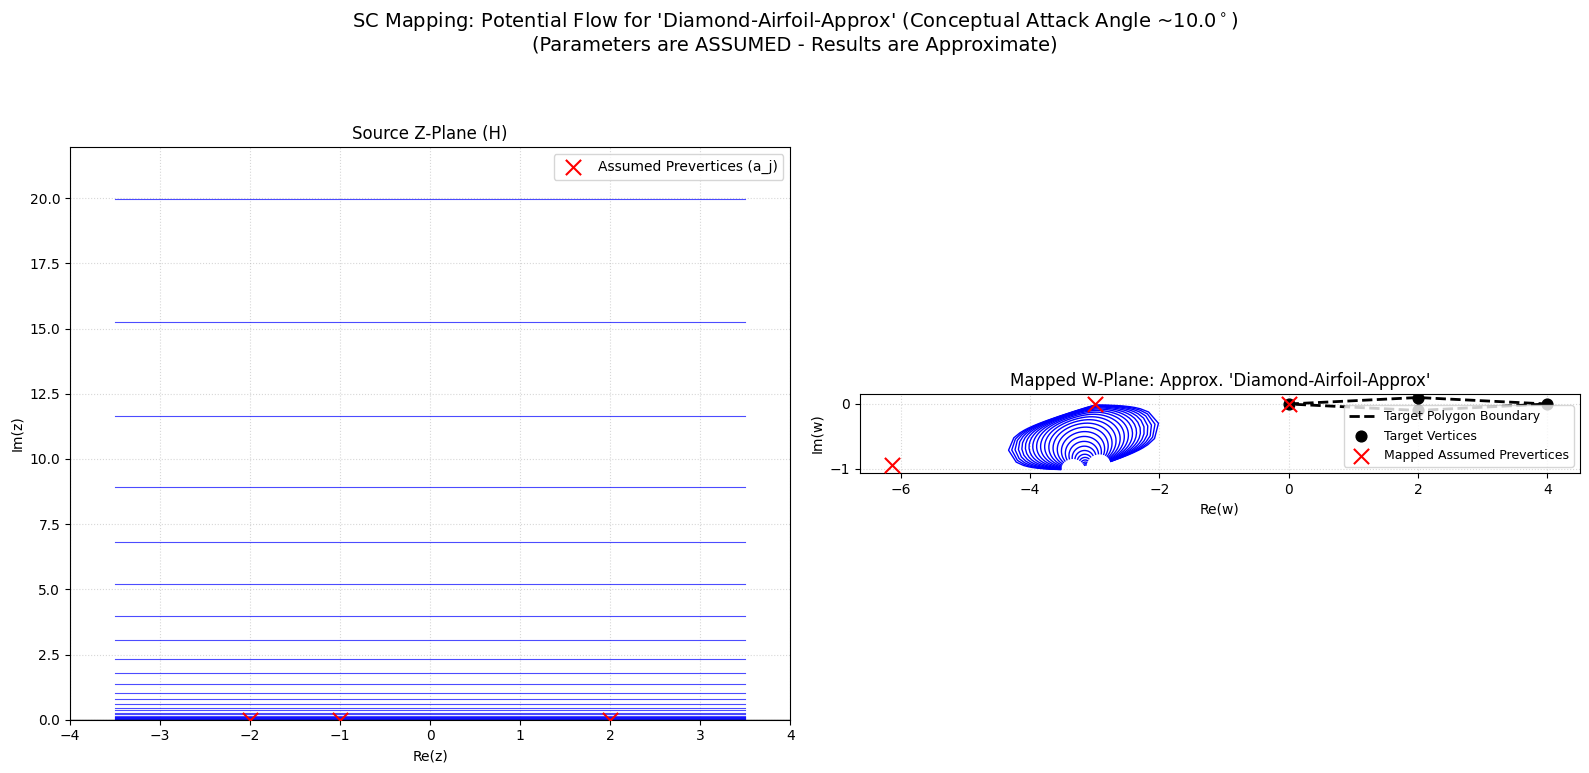


*** WARNING FOR 'Diamond-Airfoil-Approx' ***
This plot shows potential flow around a crude polygonal approximation.
1. SC Mapping is NOT ideal for smooth, curved airfoils.
2. Parameters were GUESSED, not solved - the shape mapping is inaccurate.
3. Potential flow model ignores viscosity, boundary layers, and separation.
4. Accurate airfoil analysis requires different methods (Panel Methods, CFD) and physics (Kutta condition for lift).
This visualization is for DEMONSTRATION of the code structure ONLY.
********************************************

Done.


In [5]:
# ==================================================
# SECTION 1: IMPORTS AND SETUP
# ==================================================
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import warnings

# Filter out potential warnings from complex arithmetic during integration
warnings.filterwarnings("ignore", category=integrate.IntegrationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) # Ignore overflow/invalid value in power

print(f"Setup Complete. Using NumPy {np.__version__}, SciPy {np.__version__}")

# ==================================================
# SECTION 2: POLYGON DEFINITIONS & (GUESSED) PARAMETERS
# ==================================================

def get_polygon_parameters(shape_name="L-shape"):
    """
    Returns parameters for predefined polygon shapes.
    CRITICAL: Parameters (a_prevertices_finite, C_const, A_const) are GUESSED
              and will likely produce inaccurate mappings. A parameter solver is needed.
    """
    shape_params = {}

    if shape_name == "L-shape":
        # Target: L-shape from (0,0) to (1,0) to (1,1) to (2,1) to (2,2) to (0,2)
        w_vertices = np.array([0+0j, 1+0j, 1+1j, 2+1j, 2+2j, 0+2j])
        alphas = np.array([0.5, 1.5, 0.5, 0.5, 0.5, 0.5]) # Angles: 90, 270, 90, 90, 90, 90
        # GUESSED Parameters:
        a_prevertices_finite = np.array([-2.0, -1.0, 0.0, 1.0, 2.0]) # For w_1 to w_5
        C_const = 0.5 + 0j  # Scaled down
        z0_integration_base = a_prevertices_finite[0] + 0j
        A_const = w_vertices[0] + 0j

    elif shape_name == "T-shape":
        # Target: T-shape centered roughly at origin
        w_vertices = np.array([-1+0j, 1+0j, 1+1j, 0.5+1j, 0.5+2j, -0.5+2j, -0.5+1j, -1+1j])
        alphas = np.array([0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5]) # 90, 90, 270, 90, 90, 90, 270, 90
        # GUESSED Parameters:
        a_prevertices_finite = np.array([-3, -2, -1, -0.5, 0.5, 1, 2]) # For w_1 to w_7
        C_const = 0.4 + 0j
        z0_integration_base = a_prevertices_finite[0] + 0j
        A_const = w_vertices[0] + 0j

    elif shape_name == "U-shape":
        # Target: U-shape opening upwards
        w_vertices = np.array([-1+0j, 1+0j, 1+2j, -1+2j])
        alphas = np.array([0.5, 0.5, 0.5, 0.5]) # All 90 degrees (rectangle - special case)
        # GUESSED Parameters: Assume symmetry
        # For rectangle, prevertices relate to elliptic integrals. Let's guess symmetrical ones.
        k = 0.5 # Related to aspect ratio - affects prevertex placement
        a_prevertices_finite = np.array([-1/k, -1.0, 1.0]) # For w_1 to w_3 (a4 = 1/k often used if vertex finite)
        # Let's try mapping one vertex to infinity
        a_prevertices_finite = np.array([-2.0, -1.0, 1.0]) # Guessing for w1, w2, w3 (w4 maps to inf)
        C_const = 0.8 + 0j # Adjust size
        z0_integration_base = a_prevertices_finite[0] + 0j
        A_const = w_vertices[0] + 0j

    elif shape_name == "Wedge":
        # Target: Symmetric wedge pointing right
        w_vertices = np.array([0+0j, 2+1j, 2-1j])
        # Angles: alpha*pi. E.g. 45 deg tip = 0.25pi. Two tail angles sum to (3-2) - 0.25 = 0.75
        tip_angle_frac = 0.25 # Tip angle = 0.25 * pi = 45 degrees
        tail_angle_frac = (1.0 - tip_angle_frac) / 2.0 # (Assume symmetric tail angles)
        alphas = np.array([tip_angle_frac, tail_angle_frac, tail_angle_frac]) # Order: tip, top-tail, bottom-tail
        # GUESSED Parameters:
        a_prevertices_finite = np.array([-1.0, 1.0]) # For w_1, w_2 (w_3 maps to inf)
        C_const = 1.5 + 0j # Adjust size
        z0_integration_base = a_prevertices_finite[0] + 0j # Base at tip prevertex
        A_const = w_vertices[0] + 0j # Map base to tip vertex

    elif shape_name == "Diamond-Airfoil-Approx":
        # Target: A thin diamond shape approximating a symmetric airfoil
        # EXTREME CAVEAT: SC map is NOT ideal for smooth airfoils. This is a rough demo.
        w_vertices = np.array([0+0j, 2+0.1j, 4+0j, 2-0.1j])
        # Angles: Thin angles at leading/trailing edge, obtuse at max thickness
        alpha_le = 0.1 # Small angle LE (alpha*pi)
        alpha_te = 0.1 # Small angle TE
        alpha_max = (4 - 2 - alpha_le - alpha_te) / 2.0 # Symmetric max thickness angles
        alphas = np.array([alpha_le, alpha_max, alpha_te, alpha_max])
        # GUESSED Parameters: Assume symmetry
        a_prevertices_finite = np.array([-2.0, -1.0, 2.0]) # For w_1, w_2, w_3 (w_4 maps to inf)
        C_const = 1.0 + 0j # Adjust size
        z0_integration_base = a_prevertices_finite[0] + 0j
        A_const = w_vertices[0] + 0j

    else:
        raise ValueError(f"Unknown shape_name: {shape_name}")

    shape_params['w_vertices'] = w_vertices
    shape_params['alphas'] = alphas
    shape_params['a_prevertices_finite'] = a_prevertices_finite
    shape_params['C_const'] = C_const
    shape_params['A_const'] = A_const
    shape_params['z0_integration_base'] = z0_integration_base
    shape_params['n_vertices'] = len(w_vertices)

    print(f"\n--- Parameters for: {shape_name} ---")
    print(f"Target Vertices (w): {w_vertices}")
    print(f"Interior Angles (alpha*pi): {alphas * np.pi}")
    print(f"Check: sum(alphas) = {np.sum(alphas):.2f} vs n-2 = {shape_params['n_vertices'] - 2}")
    print(f"GUESSED Finite Prevertices (a): {a_prevertices_finite}")
    print(f"GUESSED C = {C_const}")
    print(f"GUESSED A = {A_const}")
    print(f"Integration base z0 = {z0_integration_base}")
    print("------------------------------------\n")

    # Basic validation
    if not np.isclose(np.sum(alphas), shape_params['n_vertices'] - 2):
        warnings.warn(f"Sum of alpha angles ({np.sum(alphas)}) does not equal n-2 ({shape_params['n_vertices'] - 2}). Mapping might be ill-defined.")
    if len(a_prevertices_finite) != shape_params['n_vertices'] - 1:
       warnings.warn(f"Number of finite prevertices ({len(a_prevertices_finite)}) does not equal n-1 ({shape_params['n_vertices'] - 1}). Check assumptions.")


    return shape_params

# ==================================================
# SECTION 3: SC INTEGRAND AND INTEGRATION FUNCTIONS
# ==================================================

def sc_integrand_H_inf(z, C, a_finite, alpha_all):
    """ Calculates SC integrand C * Prod_{j=1}^{n-1} [ (z - a_j)^(alpha_j - 1) ] """
    prod = C + 0j
    # Ensure alpha_all corresponds to a_finite correctly - first n-1 alphas for finite a's
    alphas_finite = alpha_all[:len(a_finite)]
    for j in range(len(a_finite)):
        term = z - a_finite[j]
        power = alphas_finite[j] - 1.0
        try:
            # Use np.power for complex base and exponent
            prod *= np.power(term, power)
        except (ValueError, ZeroDivisionError, OverflowError) as e:
             # print(f"Warning: Integrand error z={z}, a_j={a_finite[j]}, power={power}. Error: {e}")
             # Return NaN for safety, or handle differently if needed
             return np.nan + 0j
    # Check for NaN/Inf in final product
    if not np.isfinite(prod):
        # print(f"Warning: Non-finite integrand value at z={z}. Value={prod}")
        return np.nan + 0j
    return prod

def complex_path_integral(func, z_start, z_end, steps=100, **kwargs):
    """ Integrates complex func along straight line z_start to z_end using quad. """
    path_vector = z_end - z_start
    if abs(path_vector) < 1e-12: return 0j, 0.0

    quad_opts = {'limit': steps, 'epsabs': 1e-7, 'epsrel': 1e-7} # Adjust tolerance
    quad_opts.update(kwargs) # Allow overriding defaults

    # Define wrappers for real and imaginary parts for quad
    real_integrand = lambda t: np.real(func(z_start + t * path_vector) * path_vector)
    imag_integrand = lambda t: np.imag(func(z_start + t * path_vector) * path_vector)

    try:
        real_integral, real_abserr = integrate.quad(real_integrand, 0, 1, **quad_opts)
        imag_integral, imag_abserr = integrate.quad(imag_integrand, 0, 1, **quad_opts)
        total_abserr = np.sqrt(real_abserr**2 + imag_abserr**2)
        result = real_integral + 1j * imag_integral
        if not np.isfinite(result): # Check result before returning
             # print(f"Warning: Non-finite integral result from {z_start} to {z_end}")
             return np.nan + 1j*np.nan, np.inf
        return result, total_abserr
    except Exception as e:
        # print(f"Integration failed from {z_start} to {z_end}: {e}")
        return np.nan + 1j*np.nan, np.inf

# ==================================================
# SECTION 4: FORWARD MAP FUNCTION
# ==================================================

def sc_map_forward_H(z, A, C, a_finite, alpha_all, z0):
    """ Calculates the SC forward map f(z) = A + integral_{z0}^{z} integrand(t) dt. """
    # Define the integrand with fixed parameters for this map
    # Need to pass parameters correctly to the integrand lambda
    integrand_to_use = lambda t: sc_integrand_H_inf(t, C, a_finite, alpha_all)

    # Perform the complex path integral from base point z0 to z
    integral_val, abserr = complex_path_integral(integrand_to_use, z0, z, steps=200)

    # Check if integration returned NaN
    if np.isnan(integral_val):
        # print(f"Warning: Mapping failed for z={z}, integral returned NaN.")
        return np.nan + 1j*np.nan

    return A + integral_val

# ==================================================
# SECTION 5: VISUALIZATION FUNCTION
# ==================================================

def plot_sc_results(streamlines_source_z, streamlines_mapped_w, polygon_params, w_mapped_prevertices, shape_name, attack_angle_deg=0):
    """ Helper function to generate the plots """
    w_vertices = polygon_params['w_vertices']
    a_prevertices_finite = polygon_params['a_prevertices_finite']

    print(f"\n--- Generating Plots for {shape_name} ---")
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    title_str = f"SC Mapping: Potential Flow for '{shape_name}'"
    if attack_angle_deg != 0:
        title_str += f" (Conceptual Attack Angle ~{attack_angle_deg:.1f}$^\circ$)"
    title_str += "\n(Parameters are ASSUMED - Results are Approximate)"
    plt.suptitle(title_str, fontsize=14, y=0.99)


    # Subplot 1: Source Z-Plane (Upper Half Plane) with Streamlines
    axs[0].set_title("Source Z-Plane (H)")
    axs[0].set_xlabel("Re(z)")
    axs[0].set_ylabel("Im(z)")
    min_x_z, max_x_z = np.inf, -np.inf
    max_y_z = -np.inf
    for z_line in streamlines_source_z:
        axs[0].plot(z_line.real, z_line.imag, 'b-', lw=0.8, alpha=0.7)
        min_x_z = min(min_x_z, z_line.real.min())
        max_x_z = max(max_x_z, z_line.real.max())
        max_y_z = max(max_y_z, z_line.imag.max())

    axs[0].scatter(a_prevertices_finite.real, np.zeros_like(a_prevertices_finite),
                   c='red', marker='x', s=120, zorder=5, label='Assumed Prevertices (a_j)')
    axs[0].set_xlim(min_x_z - 0.5, max_x_z + 0.5)
    axs[0].set_ylim(0, max_y_z * 1.1)
    axs[0].axhline(0, color='black', lw=1) # Draw real axis
    #axs[0].set_aspect('equal', adjustable='box') # Often makes plot too tall
    axs[0].legend()
    axs[0].grid(True, linestyle=':', alpha=0.5)


    # Subplot 2: Mapped Streamlines in W-plane
    axs[1].set_title(f"Mapped W-Plane: Approx. '{shape_name}'")
    axs[1].set_xlabel("Re(w)")
    axs[1].set_ylabel("Im(w)")
    for w_line in streamlines_mapped_w:
        mask = np.isfinite(w_line) # Filter out NaNs and Infs
        if np.any(mask):
            axs[1].plot(w_line[mask].real, w_line[mask].imag, 'b-', lw=1.0)

    # Plot the polygon boundary solidly
    polygon_boundary = np.append(w_vertices, w_vertices[0])
    axs[1].plot(polygon_boundary.real, polygon_boundary.imag, 'k--', lw=2.0, zorder=3, label='Target Polygon Boundary')

    # Plot target vertices as circles (related to stagnation/high curvature)
    axs[1].scatter(w_vertices.real, w_vertices.imag, c='black', marker='o', s=60, zorder=5, label='Target Vertices')

    # Plot where the assumed prevertices actually mapped
    if w_mapped_prevertices is not None and len(w_mapped_prevertices)>0:
         valid_map_mask = np.isfinite(w_mapped_prevertices)
         axs[1].scatter(w_mapped_prevertices[valid_map_mask].real, w_mapped_prevertices[valid_map_mask].imag,
                   c='red', marker='x', s=120, zorder=5, label='Mapped Assumed Prevertices')

    axs[1].set_aspect('equal', adjustable='box')
    axs[1].legend(fontsize=9)
    axs[1].grid(True, linestyle=':', alpha=0.5)
    axs[1].autoscale_view() # Auto-adjust limits

    plt.tight_layout(rect=[0, 0.03, 1, 0.94]) # Adjust layout
    plt.show()


# ==================================================
# SECTION 6: MAIN EXECUTION
# ==================================================

if __name__ == "__main__":

    # --- CHOOSE POLYGON SHAPE ---
    # shape = "L-shape"
    # shape = "T-shape"
    # shape = "U-shape"
    # shape = "Wedge"
    shape = "Diamond-Airfoil-Approx" # REMEMBER CAVEATS for this one!
    # --------------------------

    # Get parameters for the chosen shape
    try:
        params = get_polygon_parameters(shape)
    except ValueError as e:
        print(f"Error: {e}")
        exit()

    # Define streamlines in the source domain (Upper Half Plane)
    num_streamlines = 25
    # Adjust y-range based on expected scale from params['C_const']? Maybe later.
    y_stream_vals = np.logspace(-1.5, 1.3, num_streamlines) # Im(z) = constant
    # Adjust x-range to nicely contain prevertices
    x_min = params['a_prevertices_finite'].min() - 1.5
    x_max = params['a_prevertices_finite'].max() + 1.5
    x_range = np.linspace(x_min, x_max, 150) # Re(z) values

    streamlines_source_z = []
    for y_k in y_stream_vals:
        streamlines_source_z.append(x_range + 1j * y_k)

    # Apply the SC map to each point on each streamline
    streamlines_mapped_w = []
    print(f"\nMapping {num_streamlines} streamlines for '{shape}' (this may take time)...")
    total_points_to_map = num_streamlines * len(x_range)
    mapped_count = 0

    for idx, z_line in enumerate(streamlines_source_z):
        w_line = np.full_like(z_line, np.nan + 1j*np.nan, dtype=complex)
        for i, z_point in enumerate(z_line):
            # Use the forward map function
            w_line[i] = sc_map_forward_H(
                z_point,
                params['A_const'],
                params['C_const'],
                params['a_prevertices_finite'],
                params['alphas'],
                params['z0_integration_base']
            )
            mapped_count +=1
            if mapped_count % 200 == 0: # Print progress update less frequently
                 print(f"  Mapped point {mapped_count} / {total_points_to_map}")

        streamlines_mapped_w.append(w_line)
        # print(f"  Mapped streamline {idx + 1} / {num_streamlines}") # Can comment out if too verbose

    print("Streamline mapping complete.")

    # Map the prevertices to see where they land
    w_mapped_prevertices = []
    print("Mapping prevertices:")
    for idx, a_j in enumerate(params['a_prevertices_finite']):
         offset = 1e-7j # Integrate slightly into H
         if np.isclose(a_j, params['z0_integration_base']):
             w_map = params['A_const']
         else:
             w_map = sc_map_forward_H(a_j + offset, params['A_const'], params['C_const'], params['a_prevertices_finite'], params['alphas'], params['z0_integration_base'])
         # print(f"  f({a_j:.2f}) -> {w_map.real:.3f} + {w_map.imag:.3f}j") # Can comment out if too verbose
         w_mapped_prevertices.append(w_map)
    w_mapped_prevertices = np.array(w_mapped_prevertices)

    # --- CONCEPTUAL Angle of Attack ---
    # We don't change the mapping, just the interpretation / plot title
    conceptual_attack_angle = 10.0 # degrees
    # ----------------------------------

    # Visualize the results
    plot_sc_results(streamlines_source_z, streamlines_mapped_w, params, w_mapped_prevertices, shape, attack_angle_deg=conceptual_attack_angle)

    # --- Specific Warning for Airfoil Approx ---
    if shape == "Diamond-Airfoil-Approx":
        print("\n*** WARNING FOR 'Diamond-Airfoil-Approx' ***")
        print("This plot shows potential flow around a crude polygonal approximation.")
        print("1. SC Mapping is NOT ideal for smooth, curved airfoils.")
        print("2. Parameters were GUESSED, not solved - the shape mapping is inaccurate.")
        print("3. Potential flow model ignores viscosity, boundary layers, and separation.")
        print("4. Accurate airfoil analysis requires different methods (Panel Methods, CFD) and physics (Kutta condition for lift).")
        print("This visualization is for DEMONSTRATION of the code structure ONLY.")
        print("********************************************")

    print("\nDone.")

In [6]:
# ==================================================
# SECTION 1: IMPORTS AND SETUP
# ==================================================
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import warnings
import time

# Filter out potential warnings
warnings.filterwarnings("ignore", category=integrate.IntegrationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=optimize.OptimizeWarning)


print(f"Setup Complete. Using NumPy {np.__version__}, SciPy {np.__version__}")

# ==================================================
# SECTION 2: POLYGON DEFINITION (TARGET GEOMETRY ONLY)
# ==================================================

def get_target_polygon(shape_name="L-shape"):
    """
    Returns target vertices and interior angles/pi for predefined polygon shapes.
    """
    target_params = {}

    if shape_name == "L-shape":
        w_vertices = np.array([0+0j, 1+0j, 1+1j, 2+1j, 2+2j, 0+2j])
        alphas = np.array([0.5, 1.5, 0.5, 0.5, 0.5, 0.5]) # 90, 270, 90, 90, 90, 90
        # Initial guess for unknown prevertices a3, a4, a5 (assuming a1, a2 fixed)
        initial_a_guess = np.array([0.5, 1.5, 2.5]) # Needs tuning!

    elif shape_name == "T-shape":
        w_vertices = np.array([-1+0j, 1+0j, 1+1j, 0.5+1j, 0.5+2j, -0.5+2j, -0.5+1j, -1+1j]) # n=8
        alphas = np.array([0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5]) # 90, 90, 270, 90, 90, 90, 270, 90
        # Need n-3 = 5 unknown prevertices (a3..a7)
        initial_a_guess = np.array([-0.5, 0.0, 0.2, 0.4, 0.8]) # Needs tuning!

    elif shape_name == "U-shape":
        # Rectangle, n=4. Need n-3 = 1 unknown prevertex (a3)
        w_vertices = np.array([-1+0j, 1+0j, 1+2j, -1+2j])
        alphas = np.array([0.5, 0.5, 0.5, 0.5]) # All 90 degrees
        initial_a_guess = np.array([2.0]) # Guess for a3 (assuming a1=-1, a2=1 fixed)
        # Note: Fixing a1=-1, a2=1 for rectangle is common, relates to elliptic k parameter

    elif shape_name == "Wedge":
        # Symmetric wedge, n=3. Parameter problem is trivial (no unknowns if a1, a2 fixed).
        # Solver won't be called, but define for consistency.
        w_vertices = np.array([0+0j, 2+1j, 2-1j])
        tip_angle_frac = 0.25 # 45 degrees tip
        tail_angle_frac = (1.0 - tip_angle_frac) / 2.0
        alphas = np.array([tip_angle_frac, tail_angle_frac, tail_angle_frac])
        initial_a_guess = np.array([]) # No unknowns

    elif shape_name == "Diamond-Airfoil-Approx":
        # n=4. Need n-3 = 1 unknown prevertex (a3)
        w_vertices = np.array([0+0j, 2+0.1j, 4+0j, 2-0.1j])
        alpha_le = 0.1; alpha_te = 0.1
        alpha_max = (4 - 2 - alpha_le - alpha_te) / 2.0
        alphas = np.array([alpha_le, alpha_max, alpha_te, alpha_max])
        initial_a_guess = np.array([1.0]) # Guess for a3 (assuming a1=-1, a2=0 fixed)

    else:
        raise ValueError(f"Unknown shape_name: {shape_name}")

    target_params['w_vertices'] = w_vertices
    target_params['alphas'] = alphas
    target_params['n_vertices'] = len(w_vertices)
    target_params['initial_a_guess'] = initial_a_guess # Store guess with target

    print(f"\n--- Target Geometry: {shape_name} ---")
    print(f"Target Vertices (w): {w_vertices}")
    print(f"Interior Angles (alpha*pi): {alphas * np.pi}")
    print(f"Check: sum(alphas) = {np.sum(alphas):.2f} vs n-2 = {target_params['n_vertices'] - 2}")
    print(f"Initial Guess (Unknown a_k): {initial_a_guess}")
    print("------------------------------------\n")

    # Basic validation
    if not np.isclose(np.sum(alphas), target_params['n_vertices'] - 2):
        warnings.warn(f"Sum of alpha angles ({np.sum(alphas)}) does not equal n-2 ({target_params['n_vertices'] - 2}). Mapping might be ill-defined.")

    return target_params

# ==================================================
# SECTION 3: SC INTEGRAND AND INTEGRATION FUNCTIONS (Unchanged)
# ==================================================

def sc_integrand_H_inf(z, C, a_finite, alpha_all):
    """ Calculates SC integrand C * Prod_{j=1}^{n-1} [ (z - a_j)^(alpha_j - 1) ] """
    prod = C + 0j
    alphas_finite = alpha_all[:len(a_finite)]
    for j in range(len(a_finite)):
        term = z - a_finite[j]
        power = alphas_finite[j] - 1.0
        try:
            prod *= np.power(term, power)
        except (ValueError, ZeroDivisionError, OverflowError) as e:
             return np.nan + 0j
    if not np.isfinite(prod):
        return np.nan + 0j
    return prod

def complex_path_integral(func, z_start, z_end, steps=100, **kwargs):
    """ Integrates complex func along straight line z_start to z_end using quad. """
    path_vector = z_end - z_start
    if abs(path_vector) < 1e-12: return 0j, 0.0

    quad_opts = {'limit': steps, 'epsabs': 1e-7, 'epsrel': 1e-7}
    quad_opts.update(kwargs)

    real_integrand = lambda t: np.real(func(z_start + t * path_vector) * path_vector)
    imag_integrand = lambda t: np.imag(func(z_start + t * path_vector) * path_vector)

    try:
        real_integral, real_abserr = integrate.quad(real_integrand, 0, 1, **quad_opts)
        imag_integral, imag_abserr = integrate.quad(imag_integrand, 0, 1, **quad_opts)
        total_abserr = np.sqrt(real_abserr**2 + imag_abserr**2)
        result = real_integral + 1j * imag_integral
        if not np.isfinite(result):
             return np.nan + 1j*np.nan, np.inf
        return result, total_abserr
    except Exception as e:
        # print(f"Integration failed from {z_start} to {z_end}: {e}") # Can be noisy
        return np.nan + 1j*np.nan, np.inf

# ==================================================
# SECTION 4: PARAMETER PROBLEM SOLVER FUNCTION
# ==================================================

def solve_parameter_problem(target_w_vertices, alphas,
                            fixed_a_indices=[0, 1],
                            fixed_a_values=[-1.0, 0.0], # Default fix a1=-1, a2=0
                            initial_a_guess=None,
                            solver_method='lm', # Levenberg-Marquardt often good
                            verbose=False,
                            integration_eps=1e-7):
    """
    Solves the SC parameter problem for H -> Polygon (vertex n at inf) using scipy.optimize.root.
    Finds unknown prevertices a_k and complex constant C by matching side length ratios.

    Args:
        target_w_vertices (np.array): Complex target vertex coordinates (w_1, ..., w_n).
        alphas (np.array): Interior angles/pi for vertices (alpha_1, ..., alpha_n).
        fixed_a_indices (list): Indices of prevertices to fix (e.g., [0, 1] for a_1, a_2).
        fixed_a_values (list): Values for the fixed prevertices.
        initial_a_guess (np.array): Initial guess for the *unknown* prevertices.
        solver_method (str): Method for scipy.optimize.root (e.g., 'lm', 'broyden1').
        verbose (bool): Print progress information during solving.
        integration_eps (float): Absolute and relative tolerance for integration.

    Returns:
        dict: Containing 'success' (bool), 'message' (str),
              'a_prevertices_finite' (np.array | None), 'C_const' (complex | None),
              'A_const' (complex | None), 'z0_integration_base' (complex | None),
              'solver_result' (object | None)
    """
    n_vertices = len(target_w_vertices)
    n_finite_a = n_vertices - 1
    n_unknown_a = n_finite_a - len(fixed_a_indices)

    if n_unknown_a < 0:
        raise ValueError("More fixed prevertices specified than available finite prevertices.")
    if n_vertices <= 3:
        print("INFO: Solver not needed for n=3 vertices. Calculating C, A directly.")
        # Handle 3-vertex case directly (parameter problem is trivial)
        if len(fixed_a_indices) != 1 or len(fixed_a_values)!=1:
             raise ValueError("For n=3, exactly one prevertex should be fixed.")
        a1 = fixed_a_values[0]
        a_final = np.array([a1]) # Only one finite prevertex to determine C if a2=inf, a3=inf? No, need n-1=2 finite a's.
        # Let's assume convention fixes a1=-1, a2=1 for n=3 mapping to inf.
        if n_vertices == 3 and len(fixed_a_indices)==0: # Allow fixing none for n=3
             a_final = np.array([-1.0, 1.0]) # Standard choice
             fixed_a_indices = [0, 1] # Treat as fixed for C, A calc
             fixed_a_values = [-1.0, 1.0]
        elif len(fixed_a_indices) != 2:
             raise ValueError("For n=3, typically fix 2 prevertices (e.g., a1=-1, a2=1).")
        else:
             a_final = np.array(fixed_a_values)

        integrand_no_C = lambda t: sc_integrand_H_inf(t, 1.0, a_final, alphas)
        I12, _ = complex_path_integral(integrand_no_C, a_final[0] + 1e-9j, a_final[1] + 1e-9j, epsabs=integration_eps, epsrel=integration_eps)
        C_final = (target_w_vertices[1] - target_w_vertices[0]) / I12 if abs(I12) > 1e-12 else np.nan
        A_final = target_w_vertices[0] # Assume z0=a1
        z0_base = a_final[0] + 0j
        success = np.isfinite(C_final)
        return {
            'success': success, 'message': 'Direct calculation for n=3' if success else 'Failed direct calculation',
            'a_prevertices_finite': a_final if success else None,
            'C_const': C_final if success else None, 'A_const': A_final if success else None,
            'z0_integration_base': z0_base if success else None, 'solver_result': None
        }

    # --- Setup for Solver (n > 3) ---
    if len(fixed_a_indices) < 2:
         raise ValueError("Need to fix at least 2 prevertices for n>3 solver formulation.")
    if initial_a_guess is None or len(initial_a_guess) != n_unknown_a:
        # Simple default guess: linear spacing between last fixed and an arbitrary upper bound
        last_fixed_idx = fixed_a_indices[-1]
        last_fixed_val = fixed_a_values[-1]
        # Estimate range based on fixed points, very rough heuristic
        range_est = 1.0
        if len(fixed_a_indices) > 1:
            range_est = abs(fixed_a_values[-1] - fixed_a_values[0]) / (fixed_a_indices[-1] - fixed_a_indices[0] + 1e-6)

        initial_a_guess = np.linspace(last_fixed_val + 0.1 * range_est, last_fixed_val + (n_unknown_a + 0.5) * range_est, n_unknown_a)
        print(f"Warning: Using default initial guess for unknown prevertices: {initial_a_guess}")
        if len(initial_a_guess) != n_unknown_a: # Check again after calculation
             raise ValueError(f"Default initial guess length mismatch. Expected {n_unknown_a}, got {len(initial_a_guess)}")


    # --- Define the objective function for the root finder ---
    integration_cache = {} # Cache integrals for efficiency within one objective call

    def objective_function(unknown_a_values):
        # 1. Construct full tentative prevertex array 'a'
        a_tentative = np.zeros(n_finite_a, dtype=float)
        current_unknown_idx = 0
        try:
            for i in range(n_finite_a):
                if i in fixed_a_indices:
                    a_tentative[i] = fixed_a_values[fixed_a_indices.index(i)]
                else:
                    a_tentative[i] = unknown_a_values[current_unknown_idx]
                    current_unknown_idx += 1
        except IndexError:
             print("Error constructing tentative prevertices.")
             return np.full(n_unknown_a, 1e7) # Return large error

        # Check if prevertices are ordered; return large error if not
        if not np.all(np.diff(a_tentative) > 1e-10): # Allow very small gap
            # if verbose: print("Warning: Prevertices out of order or too close.")
            return np.full(n_unknown_a, 1e6) # Large error

        # Clear cache for new 'a' values
        integration_cache.clear()

        # 2. Calculate C based on the first two fixed prevertices (a_p0, a_p1)
        p0 = fixed_a_indices[0]
        p1 = fixed_a_indices[1]
        a_p0 = a_tentative[p0]
        a_p1 = a_tentative[p1]
        w_p0 = target_w_vertices[p0]
        w_p1 = target_w_vertices[p1]

        integrand_no_C = lambda t: sc_integrand_H_inf(t, 1.0, a_tentative, alphas)

        # Calculate integral for C determination segment
        integral_key_C = (p0, p1)
        I_p0_p1, err_C = complex_path_integral(integrand_no_C, a_p0 + 1e-9j, a_p1 + 1e-9j, epsabs=integration_eps, epsrel=integration_eps)
        integration_cache[integral_key_C] = (I_p0_p1, err_C)

        if not np.isfinite(I_p0_p1) or abs(I_p0_p1) < 1e-12:
            # if verbose: print(f"Warning: Integral for C is problematic: {I_p0_p1}")
            return np.full(n_unknown_a, 1e6) # Cannot determine C

        C_current = (w_p1 - w_p0) / I_p0_p1

        # 3. Set A (assuming z0=a_p0 corresponds to w_p0)
        A_current = w_p0 # Since integral from a_p0 to a_p0 is 0

        # 4. Calculate side length errors for segments involving unknown prevertices
        errors = []
        # Iterate through segments j -> j+1, where at least one endpoint index > fixed_indices[1]
        # We need n_unknown_a = n-3 errors. These correspond to sides starting from index p1.
        for j in range(p1, n_finite_a): # Segments (p1,p1+1), ..., (n-2, n-1)
            a_j = a_tentative[j]
            a_j1 = a_tentative[j+1] if j+1 < n_finite_a else np.inf # The last finite maps to w_{n-1}

            # We need the integral from a_j to a_{j+1}
            integral_key = (j, j+1)
            if integral_key not in integration_cache:
                 # Need to integrate up to a_{j+1}
                 if j+1 < n_finite_a:
                     I_j_j1, err_j1 = complex_path_integral(integrand_no_C, a_j + 1e-9j, a_tentative[j+1] + 1e-9j, epsabs=integration_eps, epsrel=integration_eps)
                     integration_cache[integral_key] = (I_j_j1, err_j1)
                 else: # Last segment integral (to infinity - not needed for side length)
                     integration_cache[integral_key] = (np.nan, np.inf) # Placeholder
                     I_j_j1 = np.nan # Not used directly

            I_j_j1, err_j1 = integration_cache[integral_key]

            if not np.isfinite(I_j_j1):
                 # if verbose: print(f"Warning: Integral for side {j}-{j+1} failed.")
                 errors.append(1e6) # Append large error
                 continue

            L_computed = abs(C_current * I_j_j1)
            L_target = abs(target_w_vertices[j+1] - target_w_vertices[j])

            if L_computed < 1e-12 or L_target < 1e-12:
                 # Use absolute difference for very small sides
                 error = L_computed - L_target
                 # Penalize zero computed length heavily if target is non-zero
                 if L_target > 1e-10 and L_computed < 1e-12: error = 1e3
            else:
                 # Log ratio error
                 error = np.log(L_computed / L_target)
            errors.append(error)

        # Ensure correct number of errors returned
        if len(errors) != n_unknown_a:
             # if verbose: print(f"Warning: Mismatch in error vector length. Expected {n_unknown_a}, got {len(errors)}")
             while len(errors) < n_unknown_a: errors.append(1e6) # Pad
             errors = errors[:n_unknown_a] # Truncate

        # Occasional printout for debugging / monitoring progress
        # if verbose and np.random.rand() < 0.05:
        #     print(f"    Obj Call - Guess: [{', '.join(f'{x:.3f}' for x in unknown_a_values)}], Errors: [{', '.join(f'{e:.3e}' for e in errors)}], Norm: {np.linalg.norm(errors):.4e}")

        return np.array(errors)

    # --- Call the solver ---
    start_time = time.time()
    if verbose: print(f"Starting solver '{solver_method}' for {n_unknown_a} unknowns...")
    try:
        sol = optimize.root(objective_function, initial_a_guess, method=solver_method, options={'disp': verbose, 'xtol': 1e-7, 'ftol':1e-7}) # Adjust tolerance
    except Exception as e:
        print(f"Solver call failed with exception: {e}")
        sol = optimize.OptimizeResult({'success': False, 'message': f'Solver raised exception: {e}'})

    end_time = time.time()
    if verbose: print(f"Solver finished in {end_time - start_time:.2f} seconds.")

    # --- Process results ---
    result = {'success': sol.success, 'message': sol.message, 'solver_result': sol}
    if sol.success:
        # Reconstruct the full prevertex array and final C, A
        final_unknown_a = sol.x
        a_final = np.zeros(n_finite_a, dtype=float)
        current_unknown_idx = 0
        for i in range(n_finite_a):
            if i in fixed_a_indices:
                a_final[i] = fixed_a_values[fixed_a_indices.index(i)]
            else:
                a_final[i] = final_unknown_a[current_unknown_idx]
                current_unknown_idx += 1

        # Final check for order
        if not np.all(np.diff(a_final) > 1e-10):
             print("Warning: Solver converged but final prevertices out of order or too close.")
             result['success'] = False
             result['message'] += " (Warning: final prevertices order/proximity issue)"
             a_final = None # Mark as invalid
             C_final = None
             A_final = None
             z0_base = None
        else:
            # Recalculate C and A with the final prevertices
            p0 = fixed_a_indices[0]
            p1 = fixed_a_indices[1]
            a_p0 = a_final[p0]
            a_p1 = a_final[p1]
            w_p0 = target_w_vertices[p0]
            w_p1 = target_w_vertices[p1]
            integrand_no_C = lambda t: sc_integrand_H_inf(t, 1.0, a_final, alphas)
            I_p0_p1, _ = complex_path_integral(integrand_no_C, a_p0 + 1e-9j, a_p1 + 1e-9j, epsabs=integration_eps, epsrel=integration_eps)

            C_final = (w_p1 - w_p0) / I_p0_p1 if abs(I_p0_p1) > 1e-12 else np.nan
            A_final = w_p0 # Assuming z0=a_p0 (first fixed prevertex)
            z0_base = a_final[p0] + 0j

            if not np.isfinite(C_final):
                print("Warning: Solver converged but failed to calculate final C.")
                result['success'] = False
                result['message'] += " (Warning: final C calculation failed)"
                C_final = None
                A_final = None


        result['a_prevertices_finite'] = a_final
        result['C_const'] = C_final
        result['A_const'] = A_final
        result['z0_integration_base'] = z0_base
        if result['success'] and verbose:
             print(f"Solver converged successfully.")
             print(f"  Final finite prevertices: {a_final}")
             print(f"  Final C = {C_final}")
             print(f"  Final A = {A_final}")

    else:
        if verbose: print(f"Solver failed to converge: {sol.message}")
        result['a_prevertices_finite'] = None
        result['C_const'] = None
        result['A_const'] = None
        result['z0_integration_base'] = None

    return result


# ==================================================
# SECTION 5: FORWARD MAP FUNCTION (Unchanged)
# ==================================================

def sc_map_forward_H(z, A, C, a_finite, alpha_all, z0, integration_eps=1e-7):
    """ Calculates the SC forward map f(z) = A + integral_{z0}^{z} integrand(t) dt. """
    if A is None or C is None or a_finite is None or alpha_all is None or z0 is None:
         print("Warning: Invalid parameters passed to sc_map_forward_H.")
         return np.nan + 1j*np.nan
    if not np.isfinite(A) or not np.isfinite(C):
         print(f"Warning: Non-finite A ({A}) or C ({C}) in sc_map_forward_H.")
         return np.nan + 1j*np.nan

    integrand_to_use = lambda t: sc_integrand_H_inf(t, C, a_finite, alpha_all)
    integral_val, abserr = complex_path_integral(integrand_to_use, z0, z, steps=200, epsabs=integration_eps, epsrel=integration_eps)

    if not np.isfinite(integral_val):
        # print(f"Warning: Mapping failed for z={z}, integral returned NaN/Inf.")
        return np.nan + 1j*np.nan

    return A + integral_val

# ==================================================
# SECTION 6: VISUALIZATION FUNCTION (Minor Updates)
# ==================================================

def plot_sc_results(streamlines_source_z, streamlines_mapped_w, target_params, computed_params, shape_name, attack_angle_deg=0, solver_msg=""):
    """ Helper function to generate the plots, using computed params """
    w_vertices = target_params['w_vertices'] # Target shape
    a_prevertices_finite = computed_params.get('a_prevertices_finite', None) # Computed/Fallback
    w_mapped_prevertices = computed_params.get('w_mapped_prevertices', None) # Mapped computed/fallback 'a'

    print(f"\n--- Generating Plots for {shape_name} ---")
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    title_str = f"SC Mapping: Potential Flow for '{shape_name}'"
    if attack_angle_deg != 0:
        title_str += f" (Conceptual Attack Angle ~{attack_angle_deg:.1f}$^\circ$)"
    if solver_msg:
         title_str += f"\nSolver Status: {solver_msg}"
    else:
         title_str += f"\n(Parameters Solved Numerically)" # Assume solved if no msg

    plt.suptitle(title_str, fontsize=14, y=0.99)


    # Subplot 1: Source Z-Plane (Upper Half Plane) with Streamlines
    axs[0].set_title("Source Z-Plane (H)")
    axs[0].set_xlabel("Re(z)")
    axs[0].set_ylabel("Im(z)")
    min_x_z, max_x_z = np.inf, -np.inf
    max_y_z = -np.inf
    if streamlines_source_z: # Check if list is not empty
        for z_line in streamlines_source_z:
            axs[0].plot(z_line.real, z_line.imag, 'b-', lw=0.8, alpha=0.7)
            min_x_z = min(min_x_z, z_line.real.min())
            max_x_z = max(max_x_z, z_line.real.max())
            max_y_z = max(max_y_z, z_line.imag.max())
    else: # Handle case with no streamlines (e.g. if mapping failed early)
        min_x_z, max_x_z, max_y_z = -2, 2, 2 # Default view

    if a_prevertices_finite is not None:
        axs[0].scatter(a_prevertices_finite.real, np.zeros_like(a_prevertices_finite),
                    c='red', marker='x', s=120, zorder=5, label='Solved Prevertices (a_j)')
        axs[0].set_xlim(min(min_x_z, a_prevertices_finite.min()) - 0.5, max(max_x_z, a_prevertices_finite.max()) + 0.5)
    else:
        axs[0].set_xlim(min_x_z - 0.5, max_x_z + 0.5)

    axs[0].set_ylim(0, max_y_z * 1.1 if max_y_z > 0 else 2)
    axs[0].axhline(0, color='black', lw=1)
    axs[0].legend()
    axs[0].grid(True, linestyle=':', alpha=0.5)


    # Subplot 2: Mapped Streamlines in W-plane
    axs[1].set_title(f"Mapped W-Plane: Approx. '{shape_name}'")
    axs[1].set_xlabel("Re(w)")
    axs[1].set_ylabel("Im(w)")
    if streamlines_mapped_w:
        for w_line in streamlines_mapped_w:
            mask = np.isfinite(w_line)
            if np.any(mask):
                axs[1].plot(w_line[mask].real, w_line[mask].imag, 'b-', lw=1.0)

    # Plot the target polygon boundary (dashed)
    polygon_boundary = np.append(w_vertices, w_vertices[0])
    axs[1].plot(polygon_boundary.real, polygon_boundary.imag, 'k--', lw=2.0, zorder=3, label='Target Polygon Boundary')

    # Plot target vertices as circles
    axs[1].scatter(w_vertices.real, w_vertices.imag, c='black', marker='o', s=60, zorder=5, label='Target Vertices')

    # Plot where the SOLVED prevertices actually mapped
    if w_mapped_prevertices is not None and len(w_mapped_prevertices)>0:
         valid_map_mask = np.isfinite(w_mapped_prevertices)
         axs[1].scatter(w_mapped_prevertices[valid_map_mask].real, w_mapped_prevertices[valid_map_mask].imag,
                   c='red', marker='x', s=120, zorder=5, label='Mapped Solved Prevertices f(a_j)')

    axs[1].set_aspect('equal', adjustable='box')
    axs[1].legend(fontsize=9)
    axs[1].grid(True, linestyle=':', alpha=0.5)
    axs[1].autoscale_view()

    plt.tight_layout(rect=[0, 0.03, 1, 0.92]) # Adjust layout
    plt.show()


# ==================================================
# SECTION 7: MAIN EXECUTION
# ==================================================

if __name__ == "__main__":

    # --- CHOOSE POLYGON SHAPE ---
    # Available: "L-shape", "T-shape", "U-shape", "Wedge", "Diamond-Airfoil-Approx"
    shape = "L-shape"
    # shape = "U-shape"
    # shape = "Diamond-Airfoil-Approx" # REMEMBER CAVEATS! Solver might struggle.
    # --------------------------

    # --- Solver Settings ---
    # Try 'lm', 'broyden1', 'krylov', 'anderson' etc.
    solver = 'lm'
    verbose_solver = False # Set to True for detailed solver output
    # -----------------------

    # Get TARGET parameters for the chosen shape
    try:
        target_params = get_target_polygon(shape)
    except ValueError as e:
        print(f"Error: {e}")
        exit()

    # --- Solve the Parameter Problem ---
    # Define fixed points (standard choice: a1=-1, a2=0 or a1=-1, a2=1)
    fixed_indices = [0, 1]
    if shape == "U-shape" or shape == "Diamond-Airfoil-Approx":
         fixed_values = [-1.0, 1.0] # Often used for symmetric shapes / rectangles
    else:
         fixed_values = [-1.0, 0.0] # Default choice

    initial_guess = target_params['initial_a_guess'] # Get guess from target params dict

    # Call the solver only if needed (n_vertices > 3)
    if target_params['n_vertices'] > 3:
        print(f"Attempting to solve parameter problem for '{shape}' using '{solver}'...")
        solver_result = solve_parameter_problem(
            target_w_vertices=target_params['w_vertices'],
            alphas=target_params['alphas'],
            fixed_a_indices=fixed_indices,
            fixed_a_values=fixed_values,
            initial_a_guess=initial_guess,
            solver_method=solver,
            verbose=verbose_solver
        )
        params_solved = solver_result # Use result from solver
        solver_msg = params_solved['message'] # Store solver message for plot title
    else:
        # Handle 3-vertex case (parameter problem is trivial or parameters assumed fixed)
        print(f"INFO: Using direct calculation/fixed parameters for '{shape}' (n=3).")
        # Use direct calculation result (already done inside solve_parameter_problem)
        params_solved = solve_parameter_problem(target_params['w_vertices'], target_params['alphas'], fixed_a_indices=fixed_indices, fixed_a_values=fixed_values)
        solver_msg = params_solved['message']


    # --- Prepare parameters for mapping ---
    # Use solved parameters if successful, otherwise create fallback placeholder dict
    if params_solved.get('success', False) and params_solved.get('a_prevertices_finite') is not None:
         print("\nParameter problem solved successfully. Using computed parameters.")
         params_to_use = params_solved
         # Ensure keys expected by mapping functions exist
         params_to_use['alphas'] = target_params['alphas']
         params_to_use['w_vertices'] = target_params['w_vertices']
         params_to_use['n_vertices'] = target_params['n_vertices']

    else:
         print("\n*****************************************************")
         print("Parameter problem solver FAILED or was skipped.")
         print("Attempting to plot using FALLBACK GUESSED parameters.")
         print("The mapped shape and prevertex locations will likely be inaccurate.")
         print(f"Solver Message: {params_solved.get('message', 'N/A')}")
         print("*****************************************************\n")
         # Create a fallback dict using guesses (define guesses here or retrieve from a modified get_target_polygon)
         # For simplicity, let's just define some basic guesses here as fallback
         n_finite_a = target_params['n_vertices'] - 1
         fallback_a = np.linspace(-1, n_finite_a - 2, n_finite_a) # Very basic guess
         fallback_C = 0.5 + 0j
         fallback_A = target_params['w_vertices'][0]
         fallback_z0 = fallback_a[0] + 0j if len(fallback_a)>0 else 0j

         params_to_use = {
              'a_prevertices_finite': fallback_a,
              'C_const': fallback_C,
              'A_const': fallback_A,
              'z0_integration_base': fallback_z0,
              'alphas': target_params['alphas'],
              'w_vertices': target_params['w_vertices'],
              'n_vertices': target_params['n_vertices'],
              'success': False # Mark as fallback
         }
         solver_msg = f"Solver Failed: {params_solved.get('message', 'N/A')} (Using Fallback Guess)"


    # --- Proceed with mapping using params_to_use ---
    if params_to_use.get('a_prevertices_finite') is None or params_to_use.get('C_const') is None:
        print("Cannot proceed with mapping - essential parameters are missing. Exiting.")
        exit()

    # Define streamlines in the source domain
    num_streamlines = 25
    y_stream_vals = np.logspace(-1.5, 1.3, num_streamlines)
    x_min = params_to_use['a_prevertices_finite'].min() - 1.5
    x_max = params_to_use['a_prevertices_finite'].max() + 1.5
    x_range = np.linspace(x_min, x_max, 150)

    streamlines_source_z = []
    for y_k in y_stream_vals:
        streamlines_source_z.append(x_range + 1j * y_k)

    # Apply the SC map using solved/fallback parameters
    streamlines_mapped_w = []
    print(f"\nMapping {num_streamlines} streamlines for '{shape}'...")
    total_points_to_map = num_streamlines * len(x_range)
    mapped_count = 0

    map_start_time = time.time()
    for idx, z_line in enumerate(streamlines_source_z):
        w_line = np.full_like(z_line, np.nan + 1j*np.nan, dtype=complex)
        for i, z_point in enumerate(z_line):
            w_line[i] = sc_map_forward_H(
                z_point,
                params_to_use['A_const'],
                params_to_use['C_const'],
                params_to_use['a_prevertices_finite'],
                params_to_use['alphas'],
                params_to_use['z0_integration_base']
            )
            mapped_count +=1
            # Print progress less often
            # if mapped_count % 500 == 0:
            #      print(f"  Mapped point {mapped_count} / {total_points_to_map}")

        streamlines_mapped_w.append(w_line)
    map_end_time = time.time()
    print(f"Streamline mapping complete ({map_end_time - map_start_time:.2f} seconds).")


    # Map the FINAL prevertices (solved or fallback)
    w_mapped_prevertices = []
    print("Mapping final prevertices:")
    map_start_time = time.time()
    for idx, a_j in enumerate(params_to_use['a_prevertices_finite']):
         offset = 1e-7j # Integrate slightly into H
         # Use the z0 defined in params_to_use
         z0_base = params_to_use['z0_integration_base']
         if np.isclose(a_j, z0_base):
             w_map = params_to_use['A_const']
         else:
             # Pass all params from params_to_use dict
             w_map = sc_map_forward_H(a_j + offset, **params_to_use) # Pass dict items as args
         w_mapped_prevertices.append(w_map)
    w_mapped_prevertices = np.array(w_mapped_prevertices)
    map_end_time = time.time()
    print(f"Prevertex mapping complete ({map_end_time - map_start_time:.2f} seconds).")


    # Store mapped prevertices in dict for plotting function
    params_to_use['w_mapped_prevertices'] = w_mapped_prevertices

    # --- CONCEPTUAL Angle of Attack ---
    conceptual_attack_angle = 0.0 # Set to non-zero to change title
    # ----------------------------------

    # Visualize the results
    plot_sc_results(streamlines_source_z, streamlines_mapped_w,
                    target_params, # Pass original target w_vertices etc
                    params_to_use, # Pass dict with computed/fallback params
                    shape,
                    attack_angle_deg=conceptual_attack_angle,
                    solver_msg=solver_msg) # Pass solver status message


    # --- Specific Warning for Airfoil Approx ---
    if shape == "Diamond-Airfoil-Approx":
        print("\n*** WARNING FOR 'Diamond-Airfoil-Approx' ***")
        print("This plot shows potential flow around a crude polygonal approximation.")
        print("1. SC Mapping is NOT ideal for smooth, curved airfoils.")
        print("2. Parameter solver may struggle; check if fallback parameters were used.")
        print("3. Potential flow model ignores viscosity, boundary layers, and separation.")
        print("4. Accurate airfoil analysis requires different methods and physics.")
        print("This visualization is primarily for DEMONSTRATION of the code structure.")
        print("********************************************")

    print("\nDone.")



Setup Complete. Using NumPy 1.25.2, SciPy 1.25.2

--- Target Geometry: L-shape ---
Target Vertices (w): [0.+0.j 1.+0.j 1.+1.j 2.+1.j 2.+2.j 0.+2.j]
Interior Angles (alpha*pi): [1.57079633 4.71238898 1.57079633 1.57079633 1.57079633 1.57079633]
Check: sum(alphas) = 4.00 vs n-2 = 4
Initial Guess (Unknown a_k): [0.5 1.5 2.5]
------------------------------------

Attempting to solve parameter problem for 'L-shape' using 'lm'...

Parameter problem solved successfully. Using computed parameters.

Mapping 25 streamlines for 'L-shape'...
Streamline mapping complete (19.68 seconds).
Mapping final prevertices:


TypeError: sc_map_forward_H() got an unexpected keyword argument 'success'